---
---

# iEEG PREPROCESSING PIPELINE
### Dartmouth ECoG Lab 
#### version 1 (2021)
#### version 2 (2024) - CC edits
#### version 3 (2024) - PB edits

---
---

In [1]:
### libraries
import pandas as pd
import mne
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#from mne import io, read_proj, read_custom_montage
from mne import io, read_proj
from mne.channels import read_custom_montage
from mne.datasets import sample
#from mne.time_frequency import psd_multitaper
from mne.time_frequency import psd_array_multitaper
import re 
from scipy import stats
from time import time
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import datetime

In [2]:
os.getcwd()

'/Volumes/rc/lab/E/ECoG/music3_IEEG/Code/Preprocessing'

In [12]:
### 1. LOAD DATA:
# Load iEEG file
subject = "Mus18" ################################################## CHANGE: SUBJECT NAME
run = "2" ################################################## CHANGE: RUN #
project_dir = "/Volumes/rc/lab/E/ECoG/music3_IEEG"

pathEDF = glob.glob(project_dir + '/Data/EDF files/' + subject + '*run' + run + '*.edf')[0]  # glob.glob finds partial string match
raw = mne.io.read_raw_edf(pathEDF, preload=True)
mne.set_log_level("WARNING")

# iEEG file info:
print('Data type: {}\n\n{}\n'.format(type(raw), raw))
print('Sample rate:', raw.info['sfreq'], 'Hz') # Get the sample rate
print('Size of the matrix: {}\n'.format(raw.get_data().shape)) # Get the size of the matrix
# print(raw.info) # VIEW INFO SUMMARY OF EEG DATA
# print('The actual data is just a matrix array!\n\n {}\n'.format(raw.get_data()))

Data type: <class 'mne.io.edf.edf.RawEDF'>

<RawEDF | Mus18_reclip_run2_BF_deidentified.edf, 276 x 2540800 (4962.5 s), ~5.23 GB, data loaded>

Sample rate: 512.0 Hz
Size of the matrix: (276, 2540800)



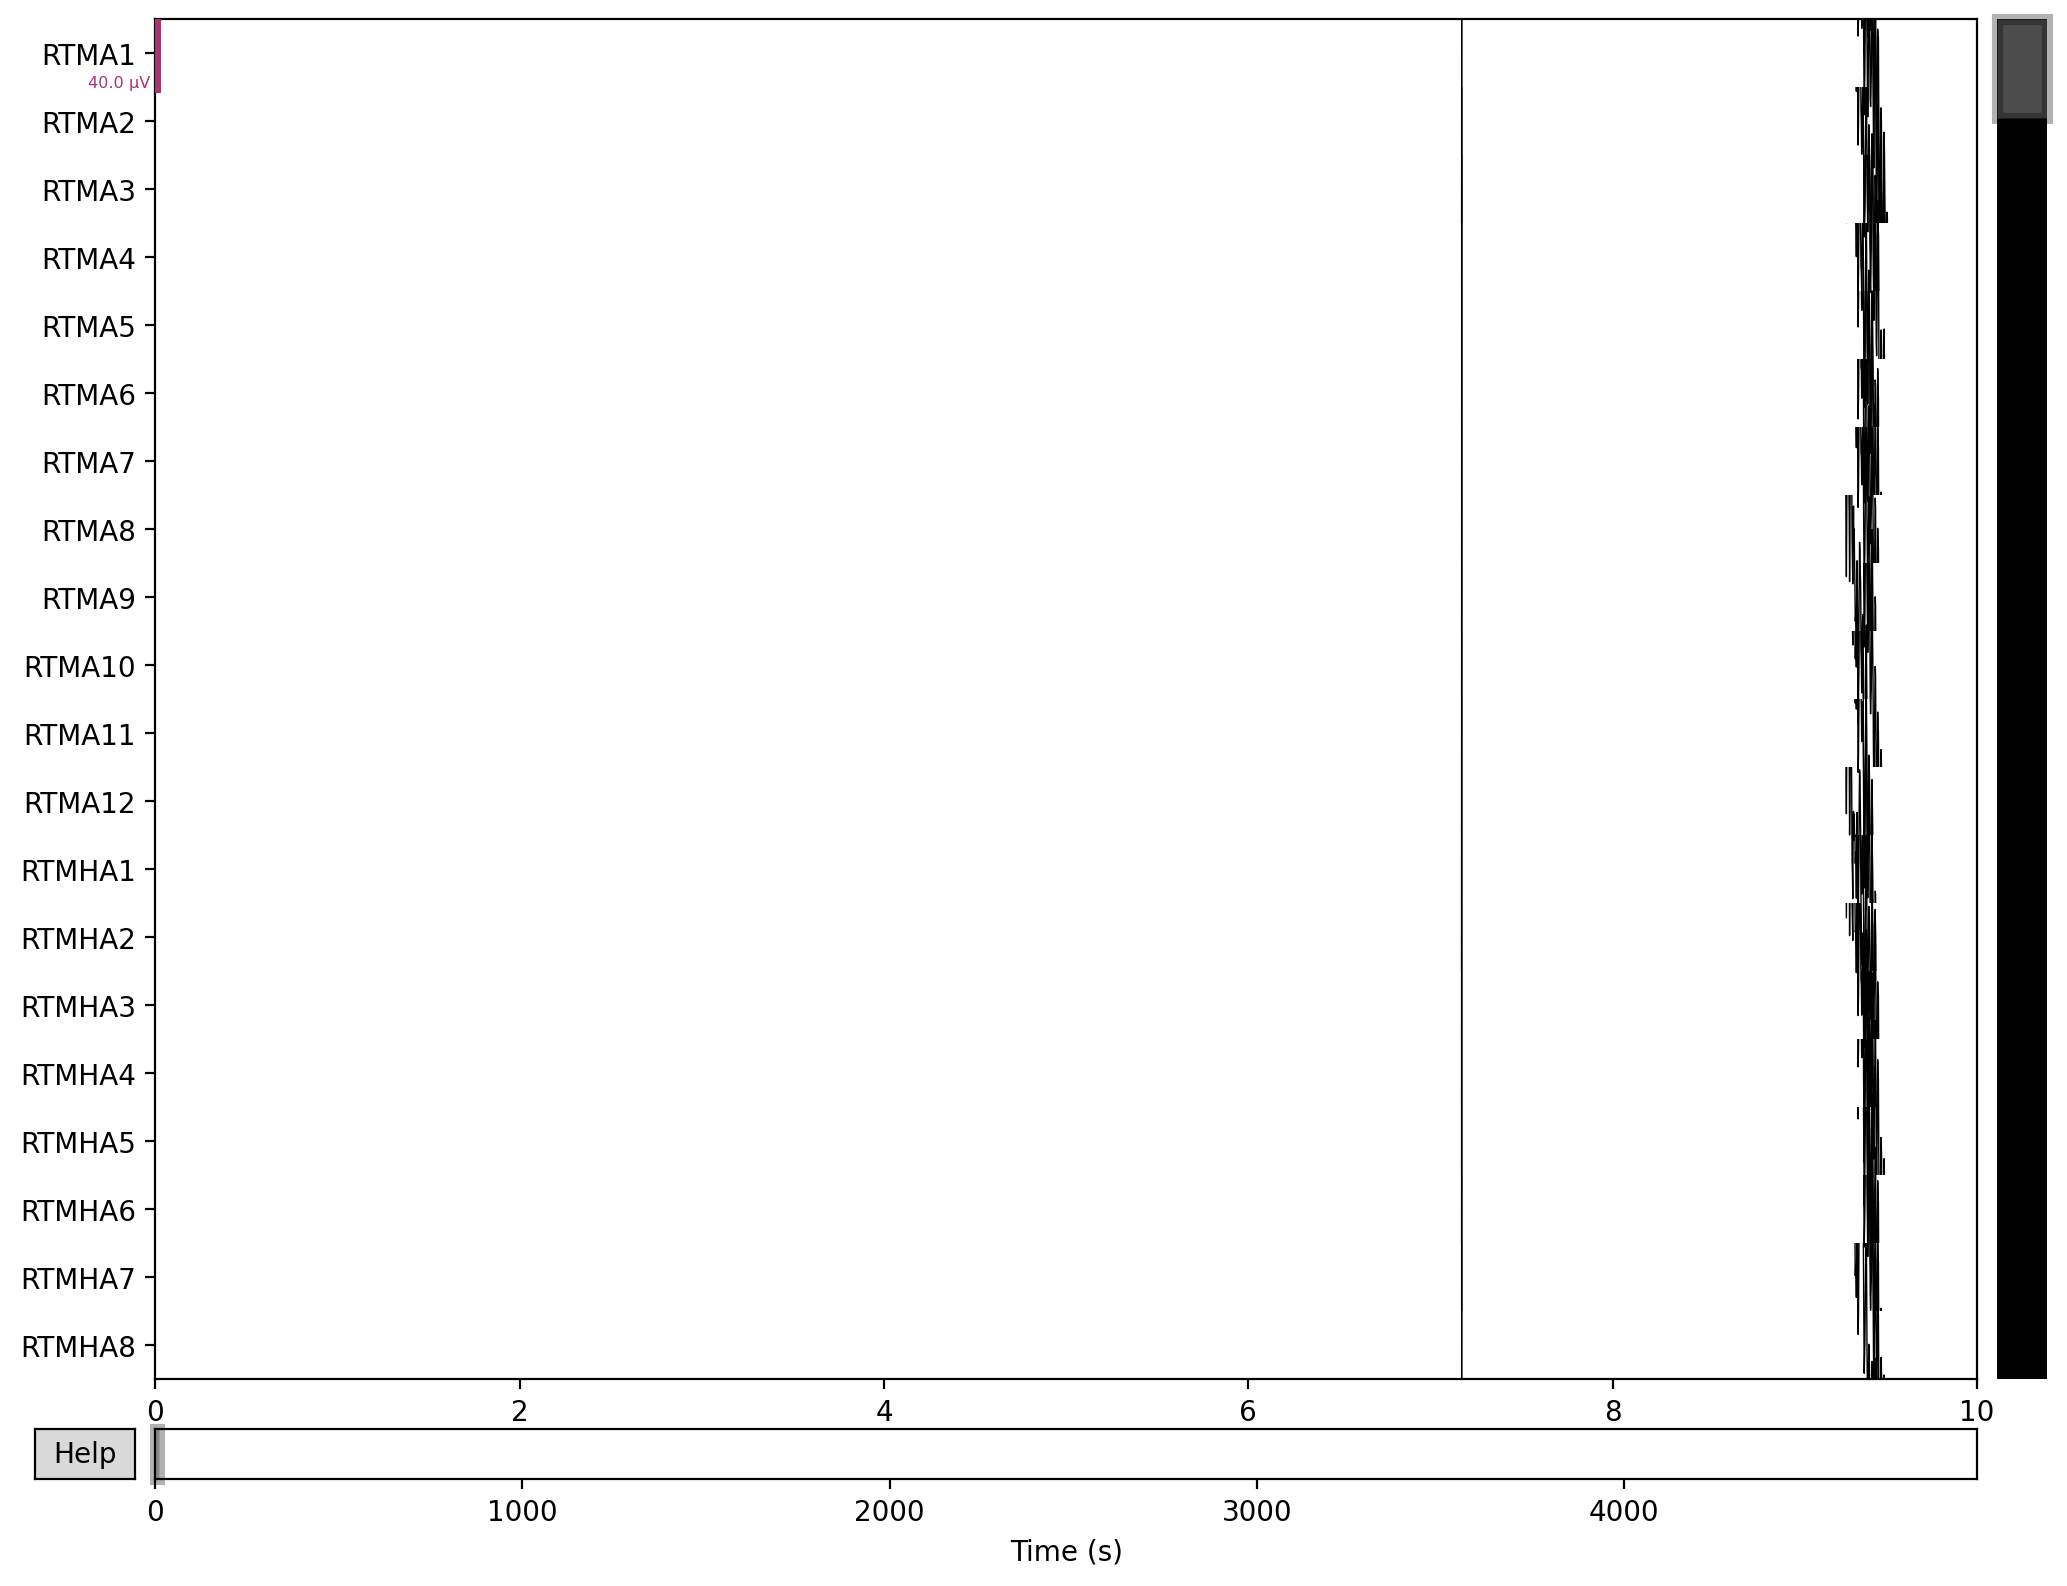

In [13]:
#plt.ion() #Makes plot interactive
#plt.switch_backend('TkAgg')
#mpl.use('Qt5Agg')
%matplotlib qt
raw.plot()
#INTRUCTIONS: Press Esc to exit once bad channels have been selected

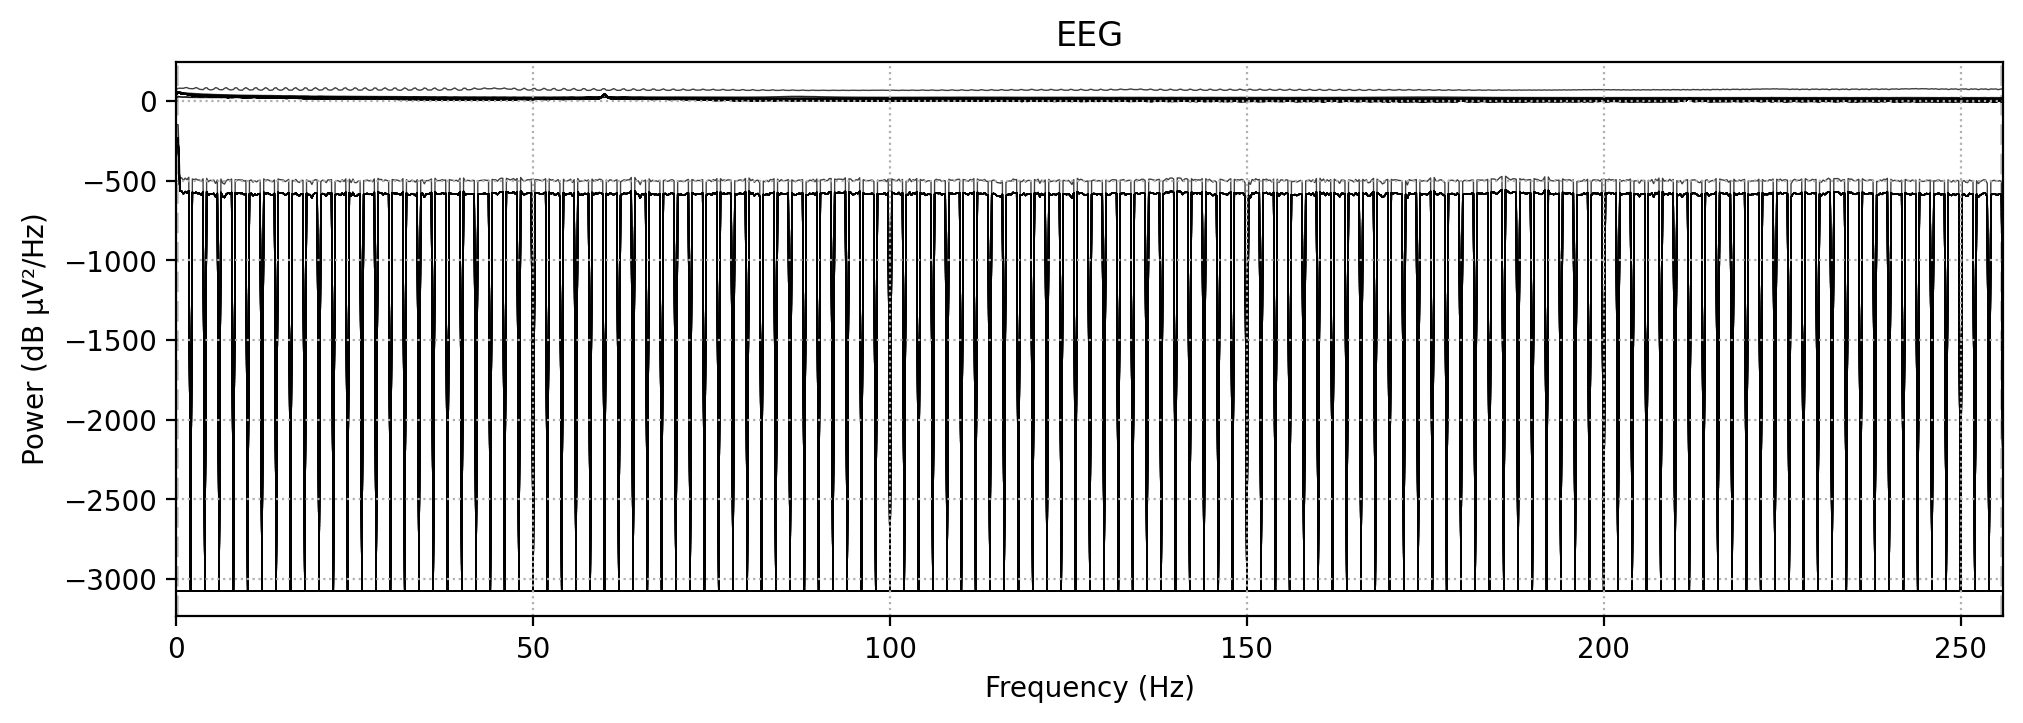

In [14]:
raw.plot_psd(tmax=np.inf, average=False)

In [15]:
### 2. CLEAN DATA:
np.bool = np.bool_ #https://stackoverflow.com/questions/74893742/how-to-solve-attributeerror-module-numpy-has-no-attribute-bool
def cleaner(raw):
    """
    iEEG PREPROCESSING PIPELINE
    INPUT: RAW iEEG (MNE)
    OUTPUT: CLEANED iEEG ('picks')
    # note: resampling should already be based on a filtered signal!
    # (i.e., first filtering, then down sampling)
    """
    ### 1. rereference data (average rereference)
    raw.set_eeg_reference('average', projection=True)
    # raw.plot_psd(area_mode='range', tmax=10.0) # visual verification
    #raw.plot_psd(area_mode='range', tmax=10.0) # visual verification

    print('Original sampling rate:', raw.info['sfreq'], 'Hz')

    ### 2. notch filter
    raw = raw.notch_filter(np.arange(60, int(raw.info['sfreq']/2)-1, 60), filter_length='auto', phase='zero') # 60, 241, 60
    # raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=n_fft,
    #              n_jobs=1, proj=True, ax=ax, color=(1, 0, 0), picks=picks) # visual verification
    #raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=n_fft,
    #              n_jobs=1, proj=True, ax=ax, color=(1, 0, 0), picks=picks) # visual verification

    ### 3. other filters 
    # low pass filter (250Hz)
    raw = raw.filter(None, 250., h_trans_bandwidth='auto', filter_length='auto', phase='zero')
    # high pass filter (1Hz) - remove slow drifts
    raw = raw.filter(1., None, l_trans_bandwidth='auto', filter_length='auto', phase='zero')
    # raw.plot_psd(area_mode='range', tmax=10.0) # visual verification
    #raw.plot_psd(area_mode='range', tmax=10.0) # visual verification


    ### 4. downsampling (200Hz)
    raw = raw.resample(200, npad='auto')
    print('New sampling rate:', raw.info['sfreq'], 'Hz')
    
    ### 5. reject bad channels
    def check_bads_adaptive(raw, picks, fun=np.var, thresh=3, max_iter=np.inf):
        ch_x = fun(raw[picks, :][0], axis=-1)
        my_mask = np.zeros(len(ch_x), dtype=np.bool)
        i_iter = 0
        while i_iter < max_iter:
            ch_x = np.ma.masked_array(ch_x, my_mask)
            this_z = stats.zscore(ch_x)
            local_bad = np.abs(this_z) > thresh
            my_mask = np.max([my_mask, local_bad], 0)
            print('iteration %i : total bads: %i' % (i_iter, sum(my_mask)))        
            if not np.any(local_bad): 
                break
            i_iter += 1
        bad_chs = [raw.ch_names[i] for i in np.where(ch_x.mask)[0]]
        return (bad_chs)
    # Find the first index of the super-bad channels
    endIndex = 1
    for i, name in enumerate(raw.info['ch_names']): # can add new logic to reject other channels that are definitely bad
        if len(re.compile(r'C\d{3}').findall(name)) > 0:
            endIndex = i
            break
    bad_chs = raw.ch_names[endIndex:]
    bad_chs.extend(check_bads_adaptive(raw, list(range(0,endIndex)), thresh=3)) 
    raw.info['bads'] = bad_chs
    #     print(bad_chs)
    #     print(len(raw.info['bads'])) # check which channels are marked as bad
    ### PICK ONLY GOOD CHANNELS:
    picks = raw.pick_types(eeg = True, meg = False, exclude = 'bads')
    print("NUMBER OF CHANNELS FOR SUBJECT {}: {}".format(subject,len(picks.info['chs'])))
    #     print("THIS SHOULD BE 0: {}".format(len(picks.info['bads'])) ) # check statement
    
    return (picks)

picks = cleaner(raw)


Original sampling rate: 512.0 Hz
New sampling rate: 200.0 Hz
iteration 0 : total bads: 5
iteration 1 : total bads: 10
iteration 2 : total bads: 15
iteration 3 : total bads: 19
iteration 4 : total bads: 21
iteration 5 : total bads: 22
iteration 6 : total bads: 22
NUMBER OF CHANNELS FOR SUBJECT Mus18: 213


In [16]:
# bad contacts from Brian's info file
info_file = pd.read_excel(f"{project_dir}/Data/music3_EDF_info.xlsx")
bad_channels_manual = info_file[(info_file["Music ID"] == subject) & (info_file["Run"] == int(run))]["Bad contacts"].values[0]
# if there are no manually marked bad channels, set as empty list
if str(bad_channels_manual) == 'nan':
    bad_channels_manual = []
else:
    bad_channels_manual = list(bad_channels_manual.split(", "))

# scalp EEG electrodes
scalp_eeg_electrodes = ['Fp1', 'FP1', 'Fp2', 'FP2', 'F7', 'F8', 'F3', 'F4', 'Fz', 'T3', 'T4', 'C3', 'C4', 'Cz', 'T5', 'T6', 'P3', 'P4', 'Pz', 'O1', 'O2']

# add scalp electrodes to bad_channels_manual (to be removed)
bad_channels_manual.extend(scalp_eeg_electrodes)
# check which ones are in patient's channels, add these to 'bad' channels along with those channels marked in the info files
channels_to_drop = set(picks.info["ch_names"]).intersection(bad_channels_manual)
picks.info['bads'].extend(channels_to_drop)

['RTMA1', 'RTMA2', 'RTMA3', 'RTMA4', 'RTMA5', 'RTMA6', 'RTMA7', 'RTMA8', 'RTMA9', 'RTMA10', 'RTMA11', 'RTMA12', 'RTMHA1', 'RTMHA2', 'RTMHA3', 'RTMHA5', 'RTMHA6', 'RTMHA7', 'RTMHA8', 'RTMHA9', 'RTMHA11', 'RTMHA12', 'RTMHB1', 'RTMHB2', 'RTMHB3', 'RTMHB4', 'RTMHB5', 'RTMHB6', 'RTMHB7', 'RTMHB8', 'RTMHB9', 'RTMHB11', 'RTMHB12', 'RTSP1', 'RTSP4', 'RTSP5', 'RTSP6', 'RTSP7', 'RTSP8', 'RTSP9', 'RTSP10', 'RTSP11', 'RTSP12', 'RTSP14', 'RTSP15', 'RTSP16', 'RTSF3', 'RTSF4', 'RTSF5', 'RTSF6', 'RTSF7', 'RTSF9', 'RTSF10', 'RTSF11', 'RTSF12', 'RTSF13', 'RTSF14', 'LTMA1', 'LTMA2', 'LTMA3', 'LTMA4', 'LTMA5', 'LTMA6', 'LTMA7', 'LTMA8', 'LTMA9', 'LTMA12', 'LTMH3', 'LTMH4', 'LTMH5', 'LTMH6', 'LTMH7', 'LTMH8', 'LTMH9', 'LTMH10', 'LTMH11', 'LTMH12', 'RFMCA1', 'RFMCA2', 'RFMCA3', 'RFMCA4', 'RFMCA5', 'RFMCA6', 'RFMCA7', 'RFMCA8', 'RFMCA9', 'RFMCA10', 'RFMCA11', 'RFMCA12', 'RFMCA13', 'RFMCA14', 'RFMO1', 'RFMO2', 'RFMO3', 'RFMO4', 'RFMO5', 'RFMO6', 'RFMO7', 'RFMO8', 'RFMO9', 'RFMO10', 'RFMO11', 'RFMO12', 'RFMO13

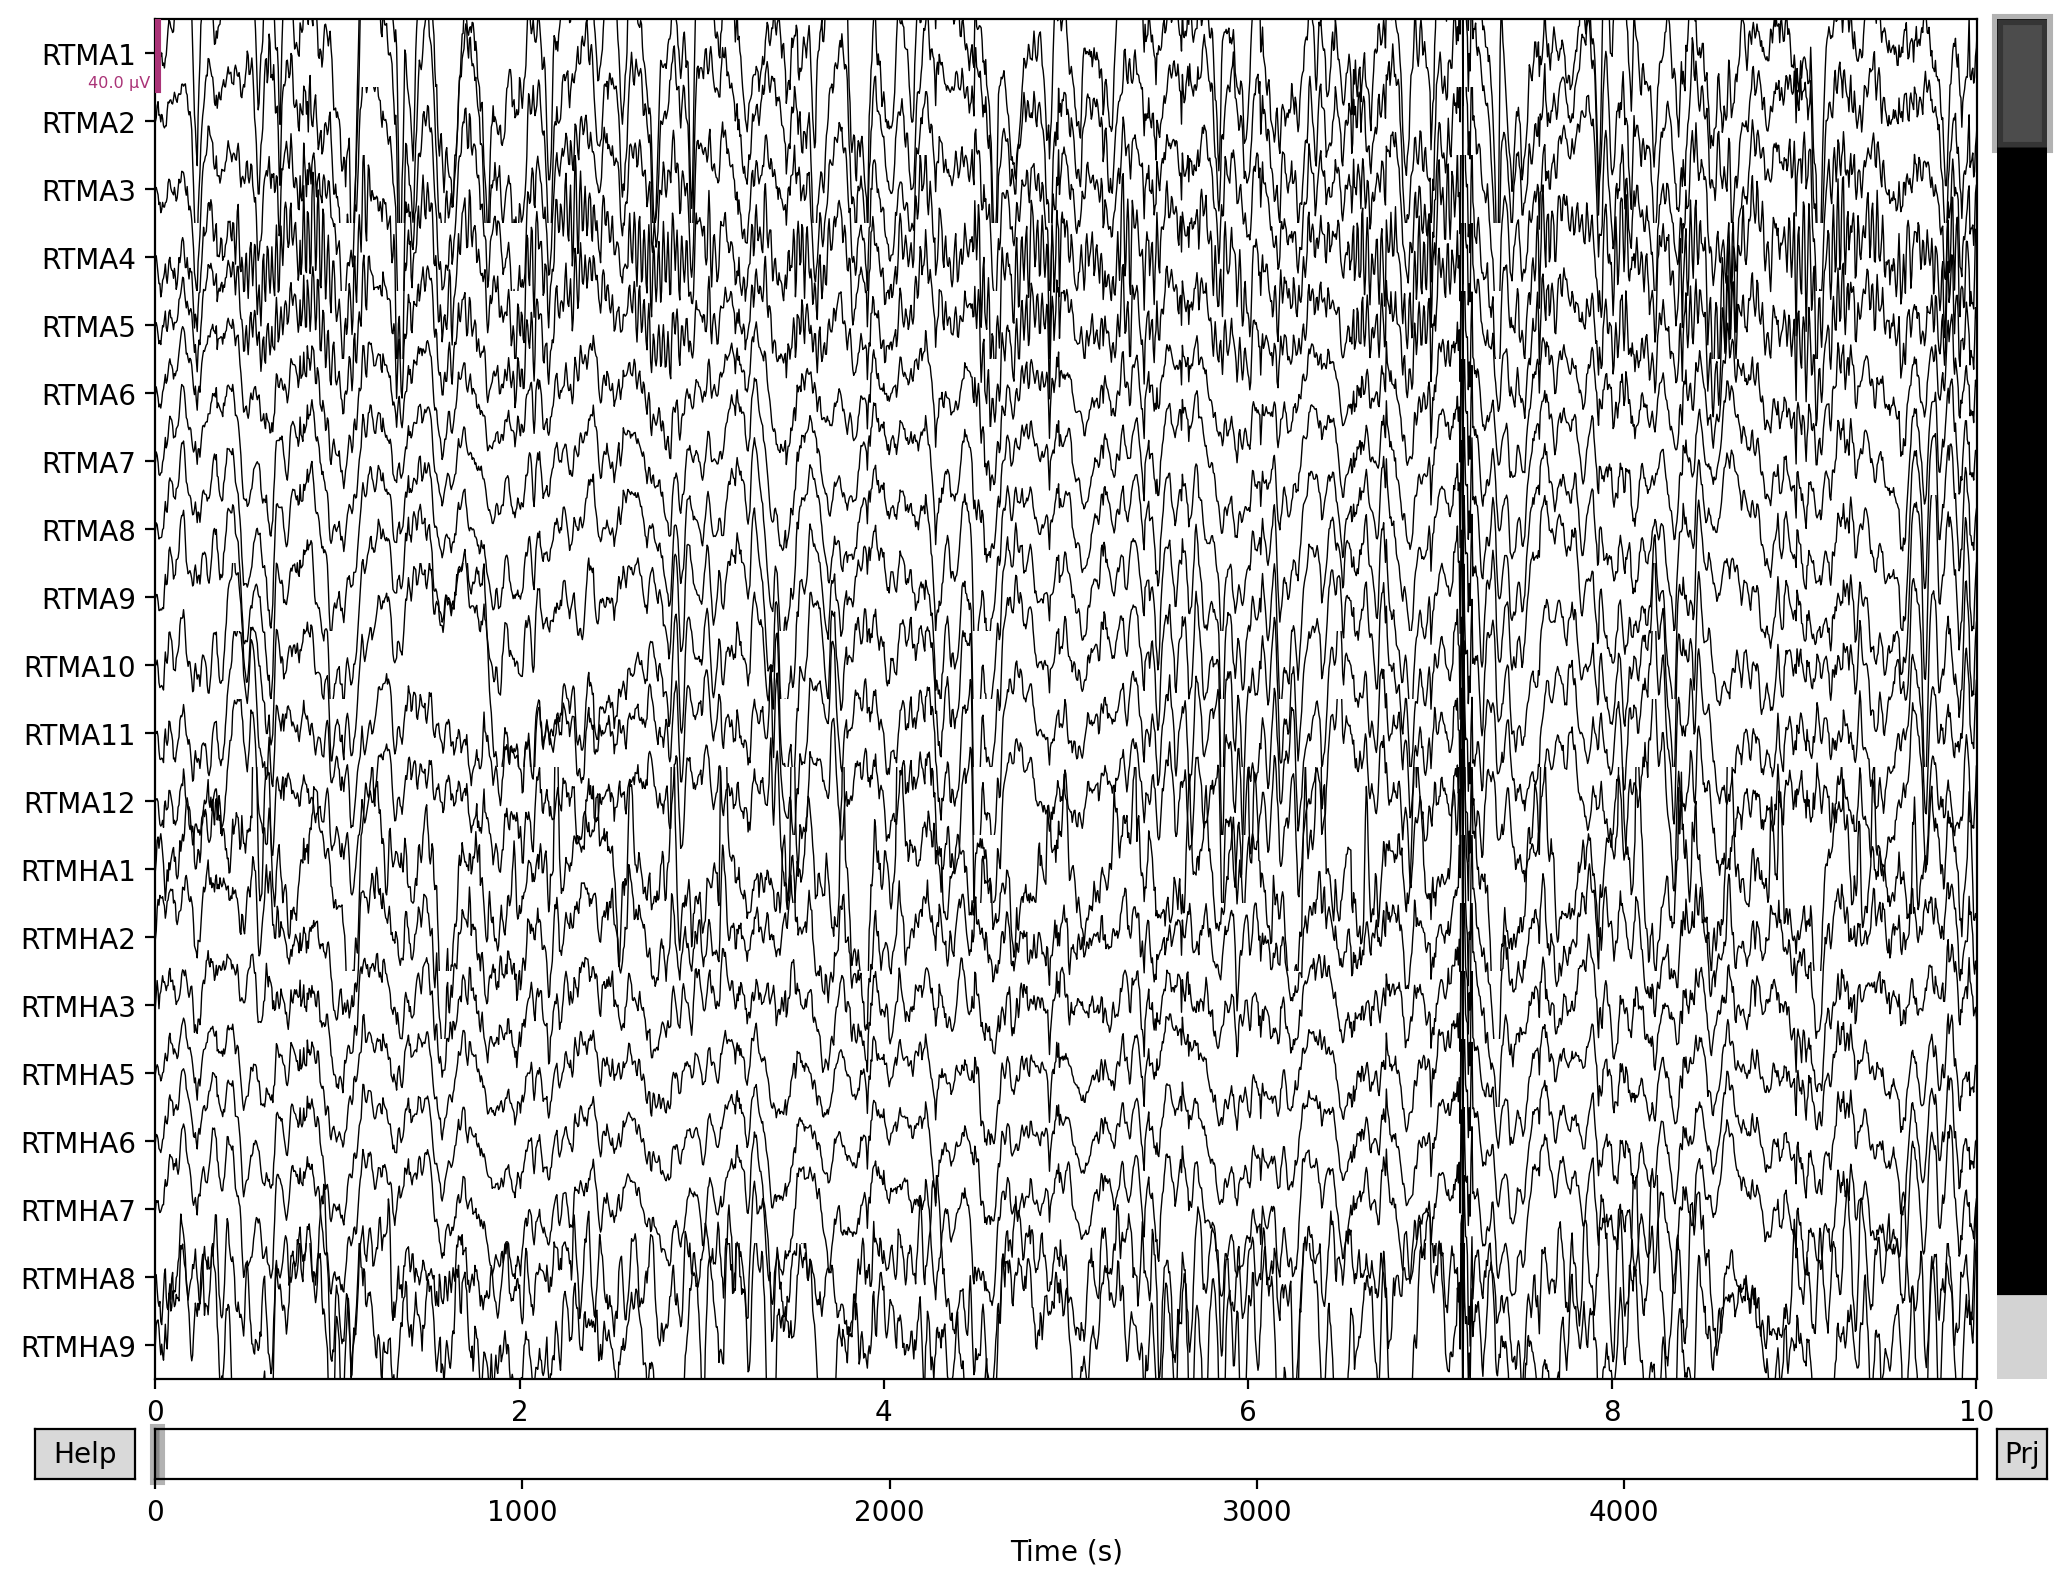

In [17]:
#https://mne.tools/stable/auto_tutorials/preprocessing/15_handling_bad_channels.html
print(picks.ch_names)
picks.plot()

In [19]:
#RUN TWICE TO ENSURE BAD CHANNELS HAVE BEEN REMOVED
print(f"Bad channels: {picks.info['bads']}")
print(f"Good channels: {picks.ch_names}")
print(f"# bad channels: {len(picks.info['bads'])}\n# good channels: {len(picks.ch_names)}")
picks = picks.pick_types(eeg = True, meg = False, exclude='bads')

Bad channels: []
Good channels: ['RTMA1', 'RTMA2', 'RTMA3', 'RTMA4', 'RTMA5', 'RTMA6', 'RTMA7', 'RTMA8', 'RTMA9', 'RTMA10', 'RTMA11', 'RTMA12', 'RTMHA1', 'RTMHA2', 'RTMHA3', 'RTMHA5', 'RTMHA6', 'RTMHA7', 'RTMHA8', 'RTMHA9', 'RTMHA11', 'RTMHA12', 'RTMHB1', 'RTMHB2', 'RTMHB3', 'RTMHB4', 'RTMHB5', 'RTMHB6', 'RTMHB7', 'RTMHB8', 'RTMHB9', 'RTMHB11', 'RTMHB12', 'RTSP1', 'RTSP4', 'RTSP5', 'RTSP6', 'RTSP7', 'RTSP8', 'RTSP9', 'RTSP10', 'RTSP11', 'RTSP12', 'RTSP14', 'RTSP15', 'RTSP16', 'RTSF3', 'RTSF4', 'RTSF5', 'RTSF6', 'RTSF7', 'RTSF9', 'RTSF10', 'RTSF11', 'RTSF12', 'RTSF13', 'RTSF14', 'LTMA1', 'LTMA2', 'LTMA3', 'LTMA4', 'LTMA5', 'LTMA6', 'LTMA7', 'LTMA8', 'LTMA9', 'LTMA12', 'LTMH3', 'LTMH4', 'LTMH5', 'LTMH6', 'LTMH7', 'LTMH8', 'LTMH9', 'LTMH10', 'LTMH11', 'LTMH12', 'RFMCA1', 'RFMCA2', 'RFMCA3', 'RFMCA4', 'RFMCA5', 'RFMCA6', 'RFMCA7', 'RFMCA8', 'RFMCA9', 'RFMCA10', 'RFMCA11', 'RFMCA12', 'RFMCA13', 'RFMCA14', 'RFMO1', 'RFMO2', 'RFMO3', 'RFMO4', 'RFMO5', 'RFMO6', 'RFMO7', 'RFMO8', 'RFMO9', 'RFMO

In [20]:
print(picks.get_data().T.shape)

(992500, 200)
(992500, 200)


In [21]:
### EXPORT DATA:
# export picks as .csv
today = datetime.datetime.today().strftime("%y%m%d")
header = ','.join(picks.ch_names)
np.savetxt(f"{project_dir}/Data/Preprocessed/{subject}_run{run}_IEEG_{today}.csv", picks.get_data().T, delimiter=',', header=header)

KeyboardInterrupt: 

# END